# Deep Learning for Image Classification

In this notebook, you will Learn how to build and train a convolutional neural network for image classification.

## I. Training a classifier

In this part, we will train a Convolutional Neural Network to classify images of 10 different classes (dogs, cats, car, ...) and see how our model performs on the test set.  


## II. Exploring CNN Architectures

This is the part where you get your hands dirty ;). Your mission is to experiment different CNN architectures and set hyperparameters in order to obtain the best accuracy on the test set!


The following command sets the backend of matplotlib to the 'inline' backend so that the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it:

In [1]:
%matplotlib inline

### Plotting functions and useful imports

You can skip this part

In [4]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
import numpy as np
# Import torch and create the alias "th"
# instead of writing torch.name_of_a_method() , we only need to write th.name_of_a_method()
# (similarly to numpy imported as np)
import torch as th


# II. Training a classifier


For this tutorial, we will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10 Dataset

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

Seed the random generator to have reproducible results:

In [7]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [8]:
num_workers = 2
test_batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 10000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



      frog      truck      truck       deer        car        car       bird      horse       ship        cat       deer      horse      horse       bird      truck      truck      truck        cat       bird       frog       deer        cat       frog       frog       bird       frog        cat        dog       deer      plane      plane      truck        car        cat       deer      plane        cat      horse        cat        cat        dog       bird       bird      horse        car        car        car       bird       bird      plane      truck        dog      horse      truck       bird       bird        dog       bird       deer        cat        car        car       ship       bird


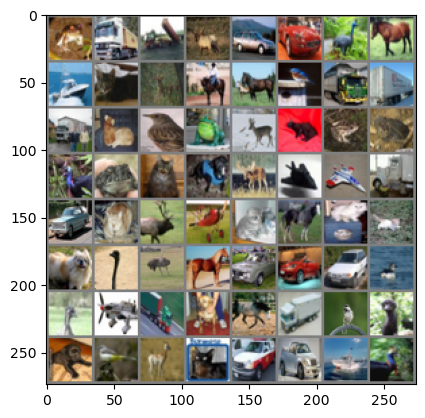

In [9]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

### 2. Define a Convolution Neural Network


In [10]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

####  Forward propagation

In PyTorch, there are built-in functions that carry out the convolution steps for you.

- **nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0):** Convolution layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#conv2d)

- **nn.MaxPool2d(kernel_size, stride=None, padding=0):** Max pooling layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#maxpool2d)

- **F.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#torch.nn.ReLU)

- **x.view(new_shape)**: Returns a new tensor with the same data but different size. It is the equivalent of numpy function *reshape* (Gives a new shape to an array without changing its data). You can read the full documentation [here.](http://pytorch.org/docs/master/tensors.html#torch.Tensor.view)

- **nn.Linear(in_features, out_features):** Applies a linear transformation to the incoming data: $y = Ax + b$, it is also called a fully connected layer. You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#linear-layers)

#### Simple Convolutional Neural Network

ConvNet with one convolution layer followed by a max pooling operation,
one fully connected layer and an output layer

In [12]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

### 3. Define a loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionally, SGD with momentum). You can read more about  [optimization methods](https://pytorch.org/docs/stable/optim.html).



In [13]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, feed the inputs to the network, and optimize



#### Data loader

In [14]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 32

In [15]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [ ]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=15, learning_rate=0.001)

Now, let's look at the evolution of the losses

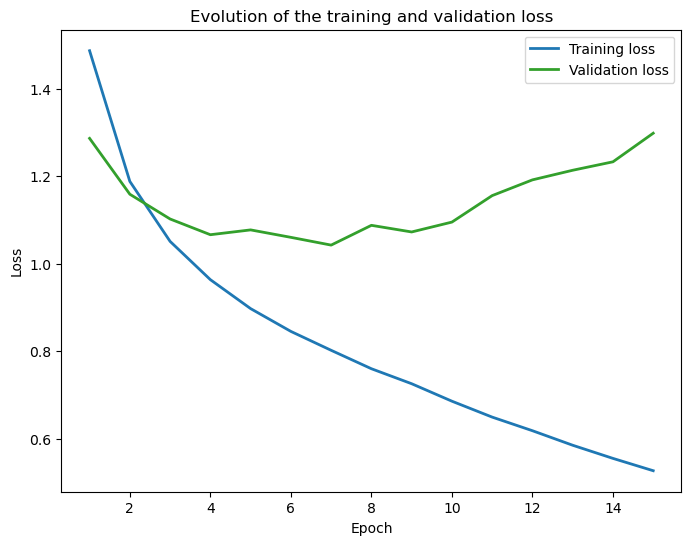

In [17]:
plot_losses(train_history, val_history)

### 5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Ground truth:

       cat       ship       ship      plane       frog       frog        car       frog        cat        car      plane      truck        dog      horse      truck       ship        dog      horse       ship       frog      horse      plane       deer      truck        dog       bird       deer      plane      truck       frog       frog        dog       deer        dog      truck       bird       deer        car      truck        dog       deer       frog        dog       frog      plane      truck        cat      truck      horse       frog      truck       ship      plane        cat       ship       ship      horse      horse       deer       frog      horse        cat       frog        cat


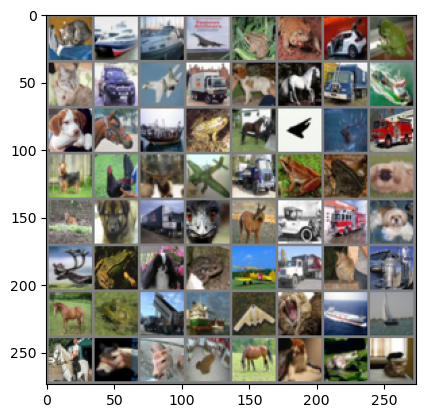

In [18]:
try:
  images, labels = next(iter(test_loader))
except EOFError:
  pass

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

Okay, now let us see what the neural network thinks these examples above are:



In [20]:
outputs = net(images.to(device))
print(outputs.size())

torch.Size([64, 10])


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is from that particular class.
So, let's get the index of the highest energy:



Predicted:

       cat        car       ship       ship       frog       frog        car       frog        cat        car      plane      truck        dog      horse      truck       ship        dog       frog       ship       frog      horse      plane      plane      truck       deer       bird       deer      plane      truck       frog       frog        dog       bird        cat      truck      truck       deer      truck      truck        dog      plane       frog      horse       frog      plane      truck        cat      truck       deer       bird      truck       ship       bird        cat       ship       ship      horse       ship        dog        cat      horse        dog       frog        cat


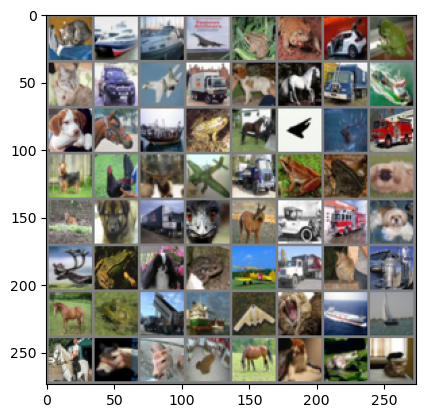

In [21]:
_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

The results seem pretty good.

Let us look at how the network performs on the whole test set.



In [22]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 50000 train images: 73.39 %
Accuracy of the network on the 10000 validation images: 64.57 %
Accuracy of the network on the 10000 test images: 63.42 %


That initial 63.97 % on the test set of images looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.
As a baseline, a linear model achieves around 30% accuracy.

What are the classes that performed well, and the classes that did not perform well?



In [23]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(predicted.size(0)):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        61.20   
car          68.30   
bird         56.90   
cat          43.60   
deer         60.80   
dog          46.10   
frog         76.00   
horse        68.30   
ship         74.90   
truck        78.10   


### Confusion Matrix

Let's look at what type of error our networks makes... 
It seems that our network is pretty good at classifying ships,
but has some difficulties to differentiate cats and dogs.
Also, it classifies a lot of trucks as cars.

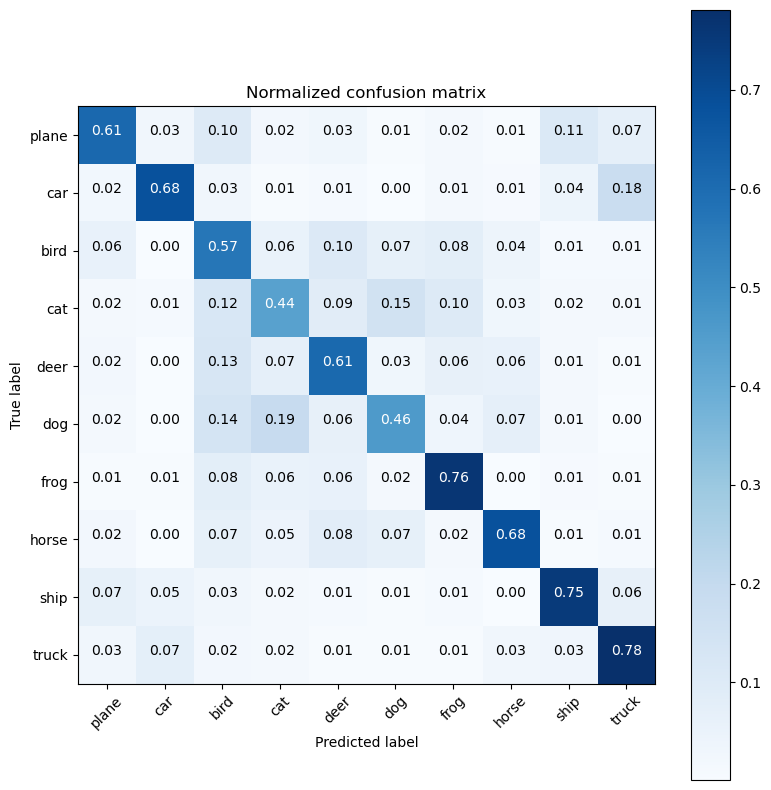

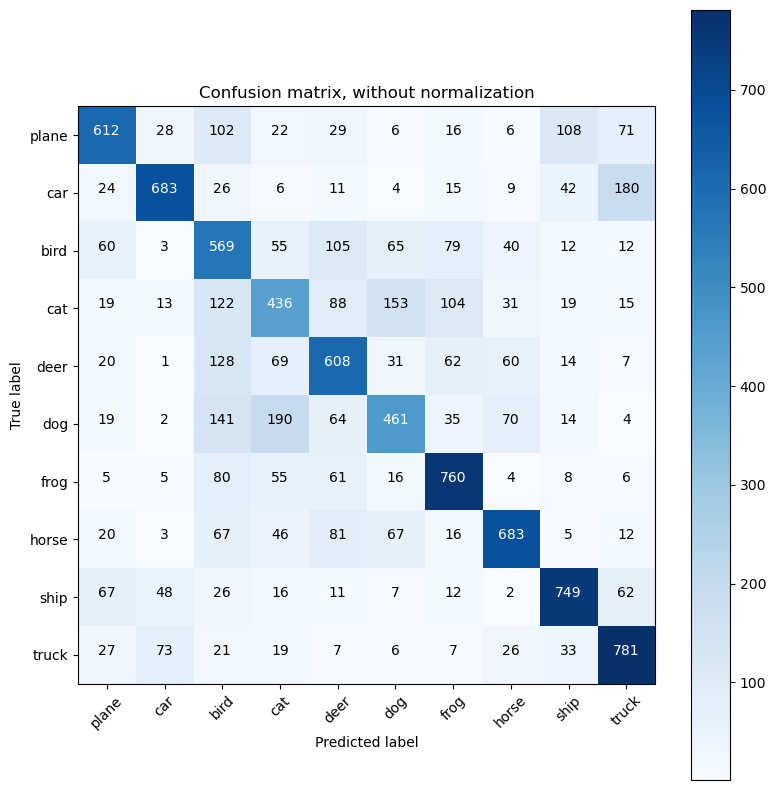

In [24]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

# III. Exploring CNN Architectures

Now, it is your turn to build a Convolutional Neural Network. The goal of this section is to explore different CNN architectures and set hyperparameters in order to obtain the best accuracy on the **test** set!

The network that you have to tweak is called **MyConvolutionalNetwork**.

You can start changing the batch_size, number of epochs and then try adding more convolutional layers.

### PyTorch functions to build the network
- **nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0):** Convolution layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#conv2d)

- **nn.MaxPool2d(kernel_size, stride=None, padding=0):** Max pooling layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#maxpool2d)

- **F.relu(Z1):** computes the element-wise ReLU of Z1 (which can be of any shape). You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#torch.nn.ReLU)

- **x.view(new_shape)**: Returns a new tensor with the same data but different size. It is the equivalent of numpy function *reshape* (Gives a new shape to an array without changing its data.). You can read the full documentation [here.](http://pytorch.org/docs/master/tensors.html#torch.Tensor.view)

- **nn.Linear(in_features, out_features):** Applies a linear transformation to the incoming data: $y = Ax + b$, it is also called a fully connected (fc) layer. You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#linear-layers)

**Convolution Formulas**:

The formulas relating the output shape $(C_2, H_2, W_2)$ of the convolution to the input shape $(C_1, H_1, W_1)$ are:


$$ H_2 = \lfloor \frac{H_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ W_2 = \lfloor \frac{W_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ C_2 = \text{number of filters used in the convolution}$$

NOTE: $C_2 = C_1$ in the case of max pooling

where:
- $H_2$: height of the output volume  
- $W_2$: width of the output volume  
- $C_1$: in_channels, number of channels in the input volume
- $C_2$: out_channels

In [12]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

#### Example of use of helper method get_output_size() 

Let's assume you have an *input volume of size 3x32x32* (where 3 is the number of channels)
and you use a 2D convolution with the following parameters:

```python
conv1 = nn.Conv2d(3, 18, kernel_size=7, stride=2, padding=1)
```
then, the size of the output volume is 18x?x? (because we have 18 filters) where ? is given by the convolution formulas (see above).

**get_output_size()** function allows to compute that size:

```
out_size = get_output_size(in_size=32, kernel_size=7, stride=2, padding=1)
print(out_size) # prints 14
```

That is to say, *the output volume is 18x14x14*

In [15]:
out_size = get_output_size(in_size=32, kernel_size=3, stride=2, padding=1)
print(out_size)

16


Below is the neural network you have to edit:

In [ ]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1) # 6 32 32
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1, padding=1)  # 10 32 32
        self.bn2 = torch.nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1)  # 16 32 32
        self.bn3 = torch.nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 16 16 16 
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)   # 32 16 16
        self.bn4 = torch.nn.BatchNorm2d(16)
        self.dp1 = torch.nn.Dropout2d(0.2)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)  # 64 14 14
        self.bn5 = torch.nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 64 7 7

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        # self.conv2 = ...
        
        # Size of the output of the last convolution:
        self.flattened_size = 64 * 7 * 7
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dp2 = torch.nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)
        
        #### START CODE: USE YOUR NEW LAYERS HERE ####
        # x = ...
        
        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608   (64 * 7 * 7 = 3136)
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=128, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.29 took: 0.89s
Epoch 1, 20% 	 train_loss: 2.05 took: 0.81s
Epoch 1, 30% 	 train_loss: 1.99 took: 0.78s
Epoch 1, 40% 	 train_loss: 1.96 took: 0.82s
Epoch 1, 51% 	 train_loss: 1.84 took: 0.77s
Epoch 1, 61% 	 train_loss: 1.69 took: 0.77s
Epoch 1, 71% 	 train_loss: 1.70 took: 0.78s
Epoch 1, 81% 	 train_loss: 1.66 took: 0.76s
Epoch 1, 92% 	 train_loss: 1.60 took: 0.79s
Validation loss = 1.47
Epoch 2, 10% 	 train_loss: 1.50 took: 0.87s
Epoch 2, 20% 	 train_loss: 1.47 took: 0.79s
Epoch 2, 30% 	 train_loss: 1.48 took: 0.79s
Epoch 2, 40% 	 train_loss: 1.42 took: 0.80s
Epoch 2, 51% 	 train_loss: 1.43 took: 0.80s
Epoch 2, 61% 	 train_loss: 1.43 took: 0.77s
Epoch 2, 71% 	 train_loss: 1.41 took: 0.78s
Epoch 2, 81% 	 train_loss: 1.39 took: 0.78s
Epoch 2, 92% 	 train_loss: 1.33 took: 0.79s
Validation loss = 1.29
Epoch 3, 10% 	 train_loss: 1.31 took: 0.92s
Epoch 3, 20% 	 train_loss: 1.28 took: 0.

### Losses Plot

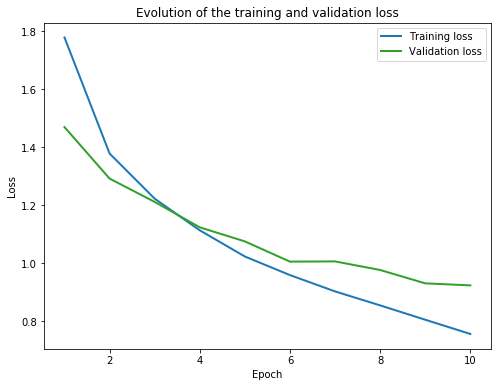

In [ ]:
plot_losses(train_history, val_history)

### Accuracy of the trained model

In [ ]:
compute_accuracy(net)

Accuracy of the network on the 50000 train images: 74.38 %
Accuracy of the network on the 10000 validation images: 68.72 %
Accuracy of the network on the 10000 test images: 68.02 %


**Baseline: Simple Convolutional Neural Network (form part II)**

<table>
<tr>
    <td>Accuracy on the test set:</td>
    <td>63.97 %</td>
</tr>
</table>

In [ ]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        68.00   
car          72.90   
bird         57.90   
cat          59.90   
deer         60.30   
dog          55.30   
frog         68.70   
horse        70.30   
ship         89.20   
truck        81.60   


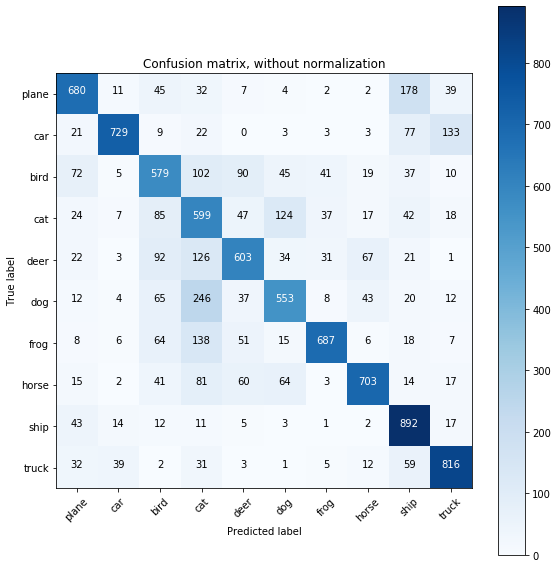

In [ ]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

### Going further

- [Coursera Course on CNN](https://www.coursera.org/learn/convolutional-neural-networks)
- [Standford Course](http://cs231n.stanford.edu/syllabus.html)
- [PyTorch Tutorial](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [How backpropagation works](neuralnetworksanddeeplearning.com/chap2.html) (Michael )

If you feel like this was too easy peasy:

-Investigate further [optimization methods](https://pytorch.org/docs/stable/optim.html) beyond SGD, and Adam and their parameters.

-Look at ways to improve your network using regularization techniques

-Look at ways to visualize network activations for model interpretability

-Use transfer learning, in order to use torchvision with pretrained=True with some pretrained models


Note: This tutorial is based on the [original PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and was adapted by [Antonin Raffin](http://araffin.github.io/) for the ROB313 course at ENSTA ParisTech. Thanks to Clement Pinard for feedback!

### More documentation/ questions to explore about Google Colab: 

-How to connect your Google Drive with Google Colab?

-How to import a new notebook and save it to your GDrive?

-How to use files which are contained in your GDrive?

Some tips [here](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)




## Extras to read later
### Visualizing Convolution parameters:
[A guide to convolution arithmetic for deep learning](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) 
by Vincent Dumoulin, Francesco Visin 


### Documentation of autograd and Function: 
[Autograd](http://pytorch.org/docs/autograd)
